In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('housing')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  827.4609985351562
final loss:  2.9903676509857178


End2end test MAPE:  0.12866493
End2end test RMSE:  3.9123979
End2end test NLLK:  3.740991
End2end test CRPS:  tensor(2.0700)


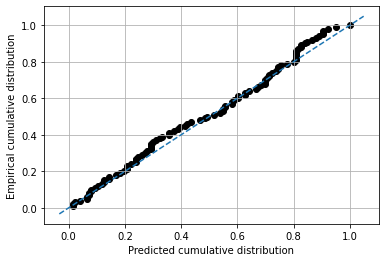

End2end test calibration error when step size is 0.001:  0.9795133534895446
End2end test calibration error when step size is 0.01:  0.09488410178886379
End2end test calibration error when step size is 0.1:  0.006701940035273376


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


  0%|                                                   | 0/10 [00:00<?, ?it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.84it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.756
  RMSE          3.912
  MDAE          1.756
  MARPD         12.817
  R2            0.834
  Correlation   0.914
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.042
  Mean-absolute Calibration Error       0.036
  Miscalibration Area                   0.036
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.162
     Group Size: 0.56 -- Calibration Error: 0.064
     Group Size: 1.00 -- Calibration Error: 0.036
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.180
     Group Size: 0.56 -- Calibration Error: 0.074
     Group Size: 1.00 -- Calibration Error: 0.042
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (7.3122554, 48.24624)
lims: (7.0, 50.0)
lims_ext: (2.7, 54.3)


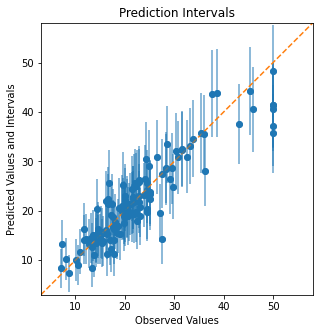

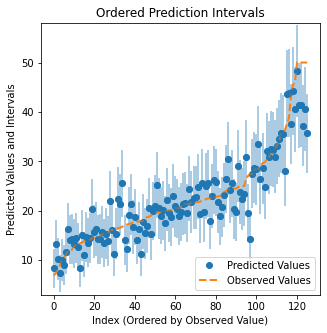

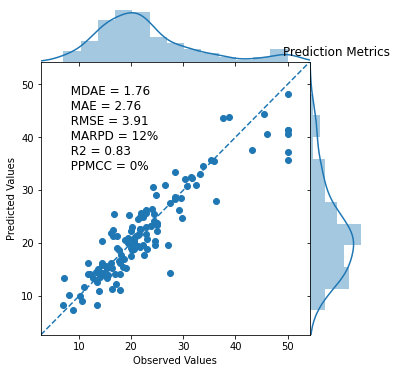

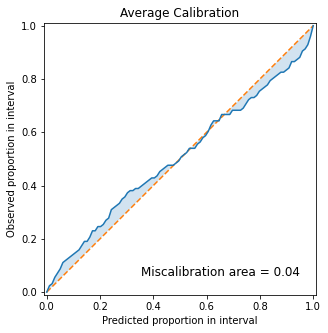

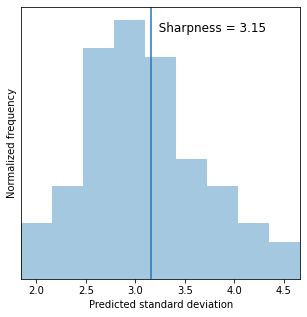

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [3]:
nllk_model = end2end_crps.train_model_nllk(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  857.1998901367188
final loss:  2.581245183944702


End2end test MAPE:  0.13644035
End2end test RMSE:  4.0844593
End2end test NLLK:  4.3590126
End2end test CRPS:  tensor(2.1933)


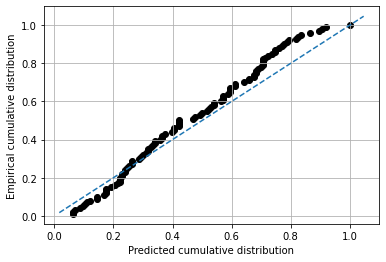

End2end test calibration error when step size is 0.001:  4.286049508692368
End2end test calibration error when step size is 0.01:  0.42109221466364344
End2end test calibration error when step size is 0.1:  0.03897707231040565


In [5]:
mean_pred, var_pred = nllk_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.23it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.87it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.864
  RMSE          4.084
  MDAE          2.030
  MARPD         13.560
  R2            0.819
  Correlation   0.907
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.103
  Mean-absolute Calibration Error       0.081
  Miscalibration Area                   0.082
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.211
     Group Size: 0.56 -- Calibration Error: 0.124
     Group Size: 1.00 -- Calibration Error: 0.081
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.229
     Group Size: 0.56 -- Calibration Error: 0.145
     Group Size: 1.00 -- Calibration Error: 0.103
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (7.225367, 49.918434)
lims: (7.0, 50.0)
lims_ext: (2.7, 54.3)


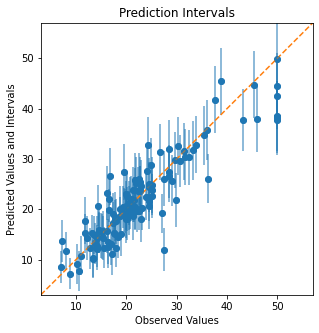

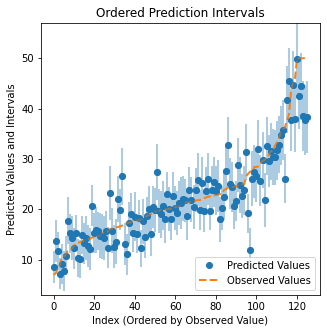

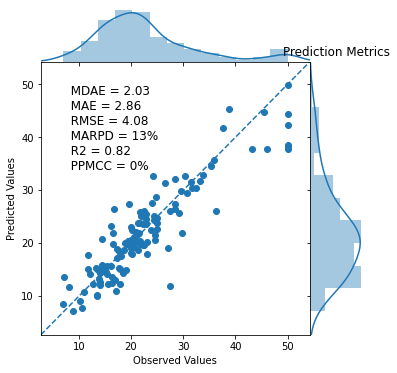

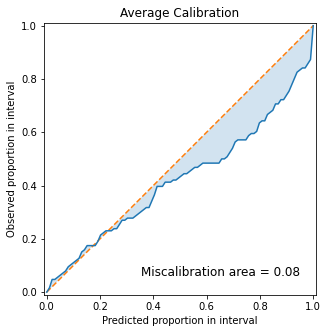

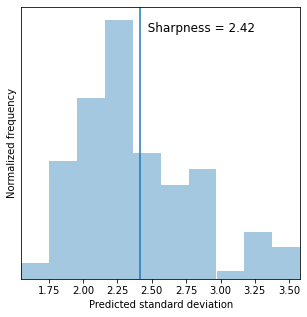

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [8]:
crps_model = end2end_crps.train_model_crps(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  22.107316970825195
final loss:  1.0475305318832397


End2end test MAPE:  0.11921308
End2end test RMSE:  3.905524
End2end test NLLK:  5.843213
End2end test CRPS:  tensor(2.0584)


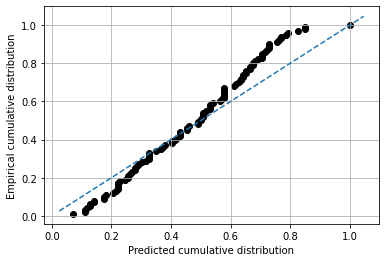

End2end test calibration error when step size is 0.001:  7.045917485512725
End2end test calibration error when step size is 0.01:  0.7003212396069541
End2end test calibration error when step size is 0.1:  0.060519022423784354


In [12]:
mean_pred, var_pred = crps_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [13]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.08it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.79it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.593
  RMSE          3.906
  MDAE          1.628
  MARPD         12.129
  R2            0.835
  Correlation   0.917
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.154
  Mean-absolute Calibration Error       0.133
  Miscalibration Area                   0.134
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.242
     Group Size: 0.56 -- Calibration Error: 0.172
     Group Size: 1.00 -- Calibration Error: 0.133
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.310
     Group Size: 0.56 -- Calibration Error: 0.201
     Group Size: 1.00 -- Calibration Error: 0.154
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (5.695766, 52.062588)
lims: (5.695766, 52.062588)
lims_ext: (1.0590838432312006, 56.69926986694336)


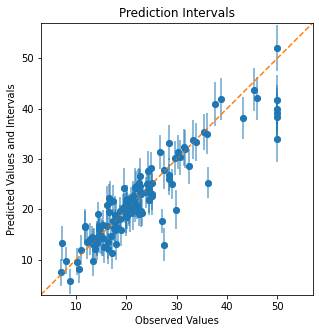

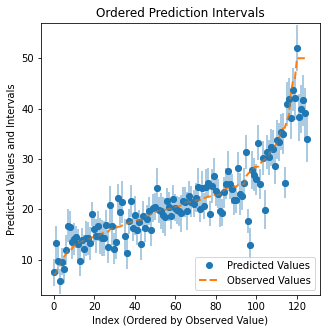

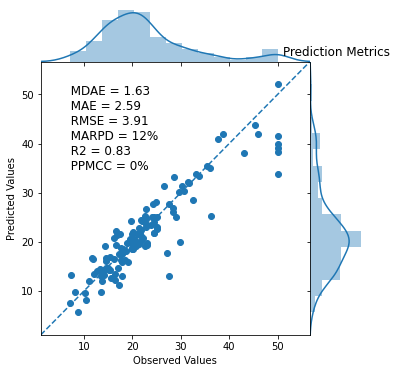

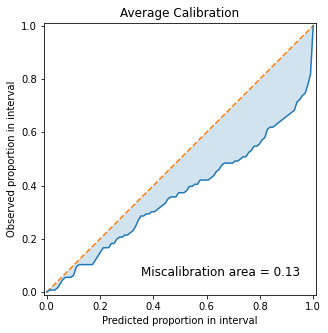

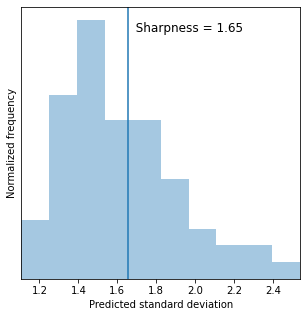

In [14]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))